## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26.4M/26.4M [00:03<00:00, 6.70MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 113kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 2.11MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.5MB/s]


In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [15]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, inp):
        out = self.model(inp)
        return out

In [16]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              ReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
       BatchNorm1d-7                  [-1, 128]             256
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 235,914
Trainable params: 235,914
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.90
Estimated T

Your experiments come here:

In [17]:
def plot_loss_and_acc(train_loss_history, val_loss_history, val_acc_history):
    clear_output(wait=True)
    epochs = range(1, len(train_loss_history) + 1)
    plt.figure(figsize=(14, 5))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, label='Train Loss')
    plt.plot(epochs, val_loss_history, '--', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train / Validation Loss')
    plt.legend()
    plt.grid(True)

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_acc_history, label='Val Acc')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [18]:
def validate_model(model, val_loader):
    loss_history = []
    acc_history = []
    
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            y_pred = model(batch_x)
            loss = loss_func(y_pred, batch_y)
            pred = torch.argmax(y_pred, dim=1)
            acc = (pred == batch_y).float().mean().item()
            loss_history.append(loss.item())
            acc_history.append(acc)

    return np.mean(loss_history), np.mean(acc_history)

In [19]:
def train(model, optimizer, loss_func, train_loader, val_loader, num_epochs, plot=True):
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    
    for _ in tqdm(range(num_epochs)):
    
        # train
        model.train()
        epoch_loss = []
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(batch_x)
            loss = loss_func(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        train_loss_history.append(np.mean(epoch_loss))
    
        # eval
        model.eval()
        val_loss, val_acc = validate_model(model, val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # plot res
        if plot:
            plot_loss_and_acc(train_loss_history, val_loss_history, val_acc_history)

    return train_loss_history, val_loss_history, val_acc_history

In [23]:
model = TinyNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = torch.nn.CrossEntropyLoss()

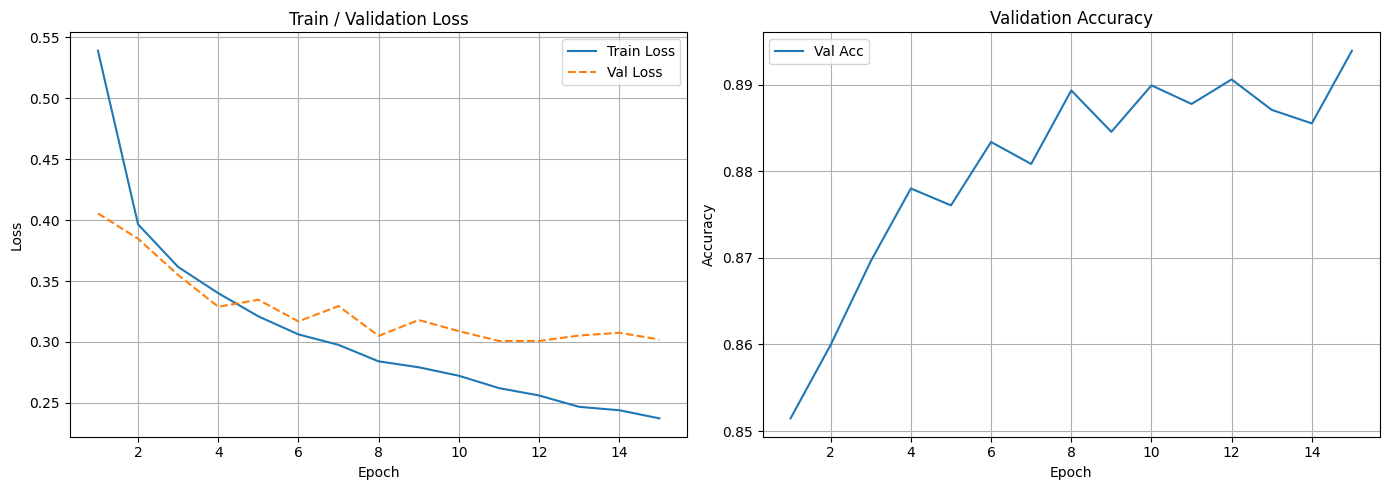

100%|██████████| 15/15 [01:27<00:00,  5.81s/it]


In [24]:
train_loss_history, val_loss_history, val_acc_history = train(
    model=model,
    optimizer=optimizer,
    loss_func=loss_func,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=15,
    plot=True
)

In [25]:
print(f"Финальная точность на валидации: {round(val_acc_history[-1], 3)}")

Финальная точность на валидации: 0.894


Финальная точность на валидации: 0.894

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [26]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [27]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.16
Estimated Total Size (MB): 2.19
----------------------------------------------------------------


In [28]:
model = OverfittingNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = torch.nn.CrossEntropyLoss()

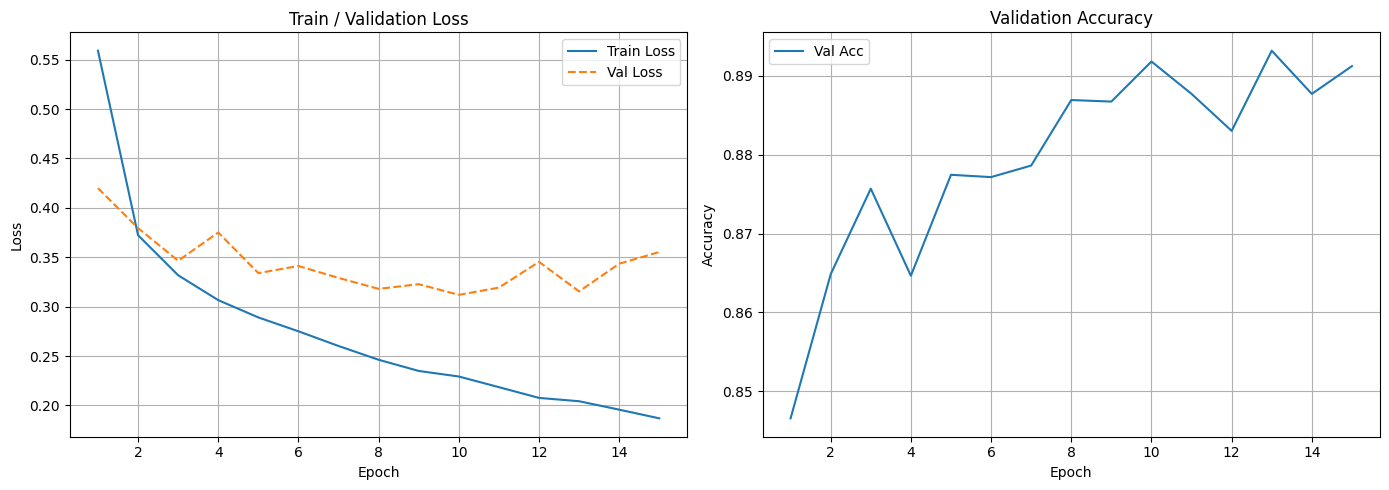

100%|██████████| 15/15 [01:25<00:00,  5.70s/it]


In [29]:
train_loss_history, val_loss_history, val_acc_history = train(
    model=model,
    optimizer=optimizer,
    loss_func=loss_func,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=15,
    plot=True
)

По графику лосса видно, что лосс на обучающий выборке сильно меньше лосса на валидации. Также начиная с 10 эпохи лосс на валидации только увеличивался, в отличие от трейна.

Посомтрим еще на точность на обучающей и валидационной выборке:

In [32]:
loss, acc = validate_model(model, train_loader)
print(f"Точность на обучающей выборке: {round(acc, 3)}")
print(f"Точность на валидационной выборке: {round(val_acc_history[-1], 3)}")

Точность на обучающей выборке: 0.931
Точность на валидационной выборке: 0.891


Точность на обучающей выборке: 0.931

Точность на валидационной выборке: 0.891

Такой результат еще раз подчеркивает, что наша модель сильно переобучена. Дальше попробуем это исправить.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [34]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [35]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [36]:
model = FixedNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = torch.nn.CrossEntropyLoss()

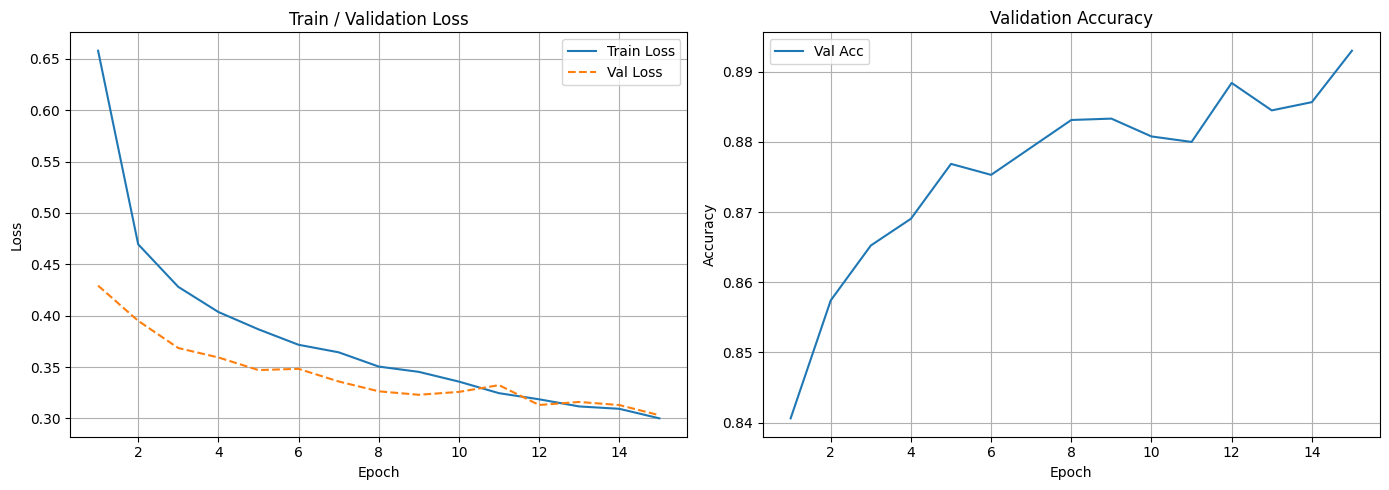

100%|██████████| 15/15 [01:27<00:00,  5.86s/it]


In [37]:
train_loss_history, val_loss_history, val_acc_history = train(
    model=model,
    optimizer=optimizer,
    loss_func=loss_func,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=15,
    plot=True
)

In [38]:
loss, acc = validate_model(model, train_loader)
print(f"Точность на обучающей выборке: {round(acc, 3)}")
print(f"Точность на валидационной выборке: {round(val_acc_history[-1], 3)}")

Точность на обучающей выборке: 0.92
Точность на валидационной выборке: 0.893


Точность на обучающей выборке: 0.92

Точность на валидационной выборке: 0.893

Из графика лосса и сравнения accuracy видно, что проблему переобучения победить удалось. Лосс на обучении и на валидации практически совпадает и уменьшается по ходу обучения. Accuracy на обучении и валидации стал отличаться сильно меньше, чем в прошлой архитектуре.

### Conclusions:
_Write down small report with your conclusions and your ideas._

Таким образом, из экспериментов следует, что добавление Dropout и BatchNormalization позволяет победить переообучение и в целом увеличить точность на тесте/валидации.